# _Notebook Jupyter_ 3_classificarAplicação

# Classificação dos modelos de motocicleta a partir da descrição

A grande dificuldade na tarefa de análise de valores compatíveis na importação de peças de motocicletas, em especial dos kits de transmissão, se dá no fato de que milhares de importadores adquirem essas peças no exterior e informam sua descrição em um campo texto livre.<br>
Nem mesmo a utilização da classificação fiscal normatizada no Mercosul, chamada de Nomenclatura Comum do Mercosul – NCM, ajuda nesse caso específico, tendo em vista que grande parte das peças de motocicletas e todos os kits de transmissão são classificados em uma mesma posição na tabela da NCM.<br>
Para que se possa tratar corretamente o dataset obtido na nossa etapa de processamento e tratamento de dados, e permitir o futuro aprendizado de máquina, com predições do modelo de motocicleta que aquele item se aplica, é preciso que primeiro se proceda a uma classificação de aplicações que futuramente será utilizado em um aprendizado supervisionado.<br>
A ideia é se aplicar uma busca na descrição da mercadoria pelos termos conhecidos de aplicações e se buscar a qual aplicação aquela descrição se refere, fazendo desse modo a primeira classificação.<br>
Posteriormente será utilizado um algorítimo de aprendizado de máquina para aprender com o próprio texto da descrição da aplicação e fazer a classificação utilizando a descrição já limpa de stopwords e outros termos desnecessários.<br>
A interseção dos dois conjuntos de classificação será o dataset utilizado para fazer o treinamento do classificador, que será o primeiro passo antes da análise de valor do item importado.

### Importa as bibliotecas necessárias

In [1]:
import pandas as pd, numpy as np
import re, time
# stopwords
from nltk.corpus import stopwords
# wordcloud
from wordcloud import WordCloud
# plotagem do gráfico
import matplotlib.pyplot as plt

In [2]:
# Data e hora da execução do script
initot=time.time()
print(f'Código executado em {time.strftime("%d/%m/%Y às %H:%M", time.localtime(time.time()))}')

Código executado em 20/01/2022 às 16:36


### Importa os dados já tratados

In [3]:
# Importa base de dados para um dataframe
df = pd.read_excel(r'./bases/dataframe.xlsx')

In [4]:
# Verifica o tamnanho do dataframe
df.shape

(18276, 3)

In [5]:
# Mostra linhas de exemplo do dataframe
df.sample(5)

,PAIS DE ORIGEM,DESCRICAO DO PRODUTO,VALOR UN.PROD.DOLAR
5908,"CHINA, REPUBLICA POP",10530002 IN KIT TRANSMISSAO P/MOTOCICLETAS(COR...,3.720000
12613,"CHINA, REPUBLICA POP","KIT DE TRANSMISSÃO PARA MOTOCICLETAS, COMPOSTO...",3.360000
12836,"CHINA, REPUBLICA POP","881606 - KIT DE TRANSMISSAO, COMPOSTO DE CORRE...",5.024464
14707,"CHINA, REPUBLICA POP",152624 # KIT TRANSMISSAO STANDARD TEMP. COMPL....,3.197229
2151,"CHINA, REPUBLICA POP",71848 - KIT NXR 150 BROS ESD (03-05) 50Z X 17Z...,5.757700


In [6]:
df['DESCRICAO DO PRODUTO'][5]

'80348 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE, COROA E PINHÃO PARA MOTOCICLETA CBX 250 TWISTER, MARCA ALLEN.'

In [7]:
type(df['DESCRICAO DO PRODUTO'][1])

str

### Importa as stopwords da língua portuguesa

In [8]:
# Importar lista de Stopwords
stopwords = set(stopwords.words('portuguese'))

In [9]:
# Mostra tamanho da lista de stopwords
len(stopwords)

204

In [10]:
# Mostra toda a lista de stopwords
swtemp = list(stopwords)
swtemp.sort()
print(swtemp)

['a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos', 'estas', 'estava', 'estavam', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéramos', 'estivéssemos', 'estou', 'está', 'estávamos', 'estão', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'forem', 'formos', 'fosse', 'fossem', 'fui', 'fôramos', 'fôssemos', 'haja', 'hajam', 'hajamos', 'havemos', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houveram', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houvermos', 'houverá', 'houverão', 'houveríamos', 'houvesse', 'houvessem', 'houvéramos', 'houvéssemos', 'há', 'hão', 'isso', 'isto', 'já', 'lhe', 'lhes', '

### Atualiza a lista de stopwords

In [11]:
# Palavras a adicionar na lista de stopwords estão contidas em um arquivo csv externo
dfsw = pd.read_csv('./bases/stopwords.csv', encoding='ISO-8859-1')
stopwords_df=sorted(list(dfsw['stopword']))
swtemp = list(stopwords_df)
swtemp.sort()
print(swtemp)

['abaixo', 'acessorios', 'acessórios', 'aco', 'acondicionados', 'adaptavel', 'adaptável', 'allen', 'almas', 'alta', 'am', 'anel', 'ano', 'aplicacao', 'aplication', 'aplicavel', 'aplicação', 'aplicável', 'application', 'ate', 'atitanium', 'aç', 'aço', 'bicicleta', 'bicycle', 'bike', 'bravo', 'cada', 'caixa', 'caixas', 'cambio', 'carbono', 'certificado', 'cever', 'chain', 'chh', 'china', 'ciclomotor', 'ciclomotores', 'cilindrada', 'cilindradas', 'cod', 'code', 'codigo', 'comando', 'combustão', 'comercial', 'comercialmente', 'commodity', 'compativel', 'compatível', 'compl', 'completo', 'completos', 'composto', 'composto', 'compostopor', 'compostpo', 'comum', 'condicao', 'condicoes', 'condição', 'condições', 'confeccionado', 'conformidade', 'conhecido', 'conj', 'conjunto', 'conjuntos', 'constituido', 'constitutivo', 'constituído', 'contendo', 'coposto', 'coroa', 'coroaes', 'corr', 'corrent', 'corrente', 'correntee', 'correntes', 'corrnte', 'cx', 'câmbio', 'cãmbio', 'código', 'decreto', 'de

In [12]:
# Atualizar stopwords
stopwords.update(stopwords_df)

In [13]:
# Mostra toda a lista de stopwords
swtemp = list(stopwords)
swtemp.sort()
print(swtemp)

['a', 'abaixo', 'acessorios', 'acessórios', 'aco', 'acondicionados', 'adaptavel', 'adaptável', 'allen', 'almas', 'alta', 'am', 'anel', 'ano', 'ao', 'aos', 'aplicacao', 'aplication', 'aplicavel', 'aplicação', 'aplicável', 'application', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'ate', 'atitanium', 'até', 'aç', 'aço', 'bicicleta', 'bicycle', 'bike', 'bravo', 'cada', 'caixa', 'caixas', 'cambio', 'carbono', 'certificado', 'cever', 'chain', 'chh', 'china', 'ciclomotor', 'ciclomotores', 'cilindrada', 'cilindradas', 'cod', 'code', 'codigo', 'com', 'comando', 'combustão', 'comercial', 'comercialmente', 'commodity', 'como', 'compativel', 'compatível', 'compl', 'completo', 'completos', 'composto', 'compostopor', 'compostpo', 'comum', 'condicao', 'condicoes', 'condição', 'condições', 'confeccionado', 'conformidade', 'conhecido', 'conj', 'conjunto', 'conjuntos', 'constituido', 'constitutivo', 'constituído', 'contendo', 'coposto', 'coroa', 'coroaes', 'corr', 'corrent', 'corrente', '

In [14]:
len(stopwords)

518

### Carrega lista de aplicações

In [15]:
# carrega a lista de marcas de motos do arquivo
dftemp=pd.read_csv('./bases/Aplicacoes.csv')

In [16]:
dftemp.head()

,APLICACOES
0,ACELLERA ACX 250F 250
1,ACELLERA FRONTLANDER 500
2,ACELLERA FRONTLANDER 800 EFI
3,ACELLERA HOTZOO SPORT 90
4,ACELLERA QUADRILANDER 300


#### Cria a lista de Palavras Chave das Aplicações

In [17]:
# remove caracteres especiais ou soltos e termos duplicados, salvando na lista
palavrasChave=sorted(set(re.sub(r"\b \w \b",
                                ' ', 
                                re.sub(r"[/<>()|\+\$%&#@\'\"]+", 
                                       " ",
                                       " ".join(dftemp['APLICACOES'].tolist()))).split()))

In [18]:
len(palavrasChave)

894

In [19]:
# amostra de palavrasChave
print(palavrasChave[:20],' ... ', palavrasChave[-20:])

['1000', '1000F', '1000R', '1000V', '1098', '1100', '1100XX', '110S', '1125', '1190', '1198', '1200', '1200Z', '125', '125R', '130', '1300', '135', '1400', '150']  ...  ['YFS', 'YS150', 'YS250', 'YZ', 'YZF', 'YZR', 'Z1000', 'Z750', 'Z800', 'ZACH', 'ZANELLA', 'ZENITH', 'ZIG', 'ZING', 'ZIP', 'ZONGSHEN', 'ZR', 'ZRX', 'ZS', 'ZZR']


In [20]:
'RT' in palavrasChave

True

### Limpeza e criação da coluna DESCRICAO

#### Função de limpeza de dados irrelevantes para a classificação e remoção de stopwords

In [21]:
def limpaDescricao(descricao): # 
    descricao=descricao.lower() #transformar em minúsculas
    # remove top (1045) e variantes
    descricao=re.sub(r'\b[ (-]*top \( *1045 *\)[-) ]*\b',' ',descricao) 
    # remove códigos numéricos entre parênteses com -*/
    descricao=re.sub(r"\( *\d*[\/\*\-\d]*\d* *\)", ' ', descricao) 
    # remove a ocorrência de "código e etc." e o termo seguinte começado com número
    # att: (alguns tem hífen ou asterisco) (colocar antes de remover pontuação)
    descricao=re.sub(r"\b(invoice|código|codigo|cod|cód|(certificado|cert)( no|nr|)|ref)[0-9a-z/\-\*\.\:]* *\d[^ ]+", ' ', descricao)
    # remove identificação de referência de engrenagens dos kits (antes da pontuação)
    #descricao=re.sub(r"([^a-z]|)(ho|uo|h|l|t|ktd|sm|m|d| x|elos )\d{1,}[ x\-\/,);.]|[ x\-\/(]*\d{1,}(ho|uo|h|l|z|t|ktd|m|d|x| dentes| elos)[ \-\/,;)]", ' ', descricao) # 00h
    descricao=re.sub(r"\d*(ho|uo|h|l|t|ktd|sm|m|d|elos )\d{1,}[ \-\/,);.]|[ \-\/(]*\d{1,}(ho|uo|h|l|z|t|ktd|m|d| dentes| elos)", ' ', descricao) # 00h
    # substitui os termos "s/re" e "s/ret" por "sem retentor"
    descricao=re.sub(r"\b(s\/re|s\/ret)\b", 'sem retentor', descricao)
    # substitui os termos "c/re" ou "c/ret" por "com retentor"
    descricao=re.sub(r"\b(c\/re|c\/ret)\b", 'com retentor', descricao)
    # substitui o termo "aplicação" e "modelo" emendado com outro
    descricao=re.sub(r"aplicacao", "aplicacao ", descricao)
    descricao=re.sub(r"modelo", "modelo ", descricao)
    # remove códigos no início da descrição
    descricao=re.sub(r"^\b\d{2,}[^ ]*\b", ' ', descricao)
    descricao=re.sub(r"^k[^ ]+", ' ', descricao)
    descricao=re.sub(r"- | -|[\\\+,.:;!?/]+", ' ', descricao) #remover pontuação (att: "- " ou " -")
    #correção de erros de digitação comuns
    termos={'titan': ['titian','tita','tintan','tit'],
            'honda': ['hond','hnda','hon'],
            'twister': ['twist', 'twiste'],
            'dafra kansas': ['dafra kan'],
            'tenere': ['tener','tenerre'],
            'broz': ['bros','bross'],
            'titan 150': ['titan150'],
            'broz 150': ['bross125.','bros125.','broz125','bross150.','bros150.','broz150'],
            'pop 100':['pop100'],
            'phoenix':['phoeni','phenix'],
            'c100': ['c 100']}
    for termo in termos:
        for termoerrado in termos[termo]:
            descricao=re.sub(r"\b"+termoerrado+r"\b", termo, descricao)
    descricao=re.sub(r"[/<>()|\+\\$%&#@\'\"]+", ' ', descricao) #remover carcteres especiais
    # remove a ocorrência de medidas tipo 00x000x00 ou 000x0000
    descricao=re.sub(r"\b\d{1,}(x|\*)\d{1,}(x|\*)\d{1,}|\d{1,}(x|\*)\d{1,}\b", ' ', descricao)
    # remove identificação de quantidades, unidades, peças e conjuntos
    descricao=re.sub(r"\b(\d* *(conj|und|uni|pc|pç|pec|peç)( \w|\w)+?)\b", ' ', descricao)
    # remove identificação de mais de 4 dígitos com ou sem letras no início e no final
    descricao=re.sub(r"\w+\d{4,}\w+", ' ', descricao)
    # remove números de 4 dígitos ou mais começados de 2 a 9
    descricao=re.sub(r"\b[02-9]\d{3,}\b", ' ', descricao)
    # remove identificação de termos começados por zero
    descricao=re.sub(r"\b0\d*\w+?(?=\b)", ' ', descricao)
    # remove a ocorrência de "marca " e o termo na lista até o próximo espaço
    for marca in ['kmc *gold','am *gold','king','bravo *racing','riffel *top']:
        descricao=re.sub(r"\bmarca[ :\./]*"+str(marca)+r"[^ ]*", ' ', descricao) # colocar antes das stopwords
    descricao=re.sub(r"marca[ :\./]*\w+", ' ', descricao)
    descricao=re.sub(r"(^-| -|- )", ' ', descricao)
    # remove stopwords mantendo a ordem original da descrição
    descricao=list(dict.fromkeys(descricao.split())) # cria lista com termos únicos
    descricao=" ".join([x for x in descricao if x not in set(stopwords)]) # exclui stopwords
    # limpa os número que não estão na lista de aplicações (colocar depois das stopwords)
    desc=descricao.upper().split() # quebra a descrição
    dif=list(set(descricao.upper().split()).difference(palavrasChave)) # pega os termos diferentes de palavrasChave
    [desc.remove(x) for x in desc if (x in dif and x.isnumeric())] # exclui de desc os termos numéricos diferentes
    descricao=" ".join(desc).lower() # volta para texto
    #remover hífen, letras ou números soltos (deixar duplicado mesmo)
    descricao=re.sub(r"(^-| -|- |\b\w\b)", ' ', descricao)
    descricao=re.sub(r"(^-| -|- |\b\w\b)", ' ', descricao)
    #substitui remove o i das cilindradas: ex.: 125i por 125
    termos=re.findall(r"\d{1,}i\b",descricao)
    if termos:
        for termo in termos:descricao=descricao.replace(termo,termo[:-1])
    # remove espaços em excesso (colocar no final)
    descricao=re.sub(r" {2,}", ' ', descricao)
    descricao=descricao.strip()
    # retorna a descricao como saída da função
    return descricao # retorna a descrição

#### Exemplo de execução da função

In [22]:
linha=745

In [23]:
df.iloc[linha]['DESCRICAO DO PRODUTO']

'KIT TRANSMISSÃO PARA MOTOCICLETAS,COMPOSTO DE CORRENTE,PINHAO E COROA,PARA MODELOS DIVERSOS DE MOTOCICLETAS (KIT C 100 BIZ (13-15) 34Z X 14Z WITH CHAIN 428H X 108L - TITANIUM (1045)) MODELO KIT C 100 BIZ (13-15) 34Z X 14Z WITH CHAIN 428H X 108L - TIT'

In [24]:
limpaDescricao(df.iloc[linha]['DESCRICAO DO PRODUTO'])

'c100 biz titan'

#### Execução da função para criação da coluna DESCRICAO limpa

In [25]:
ini=time.time()
df['DESCRICAO']=df['DESCRICAO DO PRODUTO'].apply(limpaDescricao)
fim=time.time()
print(f'Tempo de execução: {fim-ini:.2} segundos.')

Tempo de execução: 7.8 segundos.


In [26]:
df.sample(5)

,PAIS DE ORIGEM,DESCRICAO DO PRODUTO,VALOR UN.PROD.DOLAR,DESCRICAO
10292,"CHINA, REPUBLICA POP",-54T17T/428H132L - KIT TRANSMISSAO EM ACO COMP...,3.600100,
1897,"CHINA, REPUBLICA POP",ENGRENAGENS PARA TRANSMISSÃO DE MOTOCICLETAS E...,3.713600,c100 biz
12069,"CHINA, REPUBLICA POP",10530031 IN KIT TRANSMISSAO P/MOTOCICLETAS(COR...,3.744000,spee
2927,"CHINA, REPUBLICA POP",007308# KIT TRANSMISSAO STANDARD TEMP. COMPL. ...,3.221500,suzuki yes intruder katana 125
12202,"CHINA, REPUBLICA POP",91256 KIT CG 160 TITAN (16-19) / CG 160 FAN (1...,9.711875,cg 160 titan fan start cargo


In [27]:
df['DESCRICAO'].iloc[linha]

'c100 biz titan'

### Criação de colunas Modelo

#### Função de determinação de palavras chave na coluna Modelo

In [28]:
def achaPalavraChave(descricao):
    palavras=[]
    descricao=descricao.upper()
    desc=descricao.split()
    for palavra in palavrasChave:
        if palavra in desc:
            palavras.append(palavra)
        else:
            if palavra.isnumeric():
                pat=r"[0-9]*"+str(palavra)+r"[0-9]*"
            elif palavra.isalpha():
                pat=r"[A-Z]*"+str(palavra)+r"[A-Z]*"
            else:
                pat=r"\b"+palavra+r"\b"
            a = re.findall(pat,descricao)
            if len(a)>0:
                 # adiciona resultado nas palavras se o resultado estiver em palavrasChave
                palavras+=[a[i] for i in range(len(a)) if a[i] in palavrasChave]
    palavras=list(set(palavras)) # remove duplicados
    palavras=" ".join(palavras) # converte para string
    return palavras.lower()

In [29]:
achaPalavraChave(limpaDescricao(df['DESCRICAO DO PRODUTO'].iloc[linha]))

'c100 titan biz'

#### Função para acrescentar a marca da motocicleta

In [30]:
# termos que iniciam item da descrição correspondem a marca
# As que começam com espaço devem permanecer assim, pois há outros modelos com o mesmo final
Marcas = {'HONDA': ['CG','CD','CBX','CB','CBR','CRF','BIZ','BROS','BROZ','XL',' FAN','XR','XRE'
                    'DREAM','TITAN','TODAY','TWIN','POP','NX','NXR','TWISTER', 'HORNET',
                    'AMERICA','BOLDOR','DUTY','FIREBLADE','FURY','WING','LEAD','MAGNA','NL',
                    ' NC','NSR','NC','NXR','PACIFIC','COAST','SHADOW',' STRADA','STUNNER','HAWK',
                    'SUPERBLACKBIRD','TORNADO','TURUNA','XRV','AFRICA','VALKYRIE','VARADERO',
                    'VFR','VLR','VTR','VTX','TRANSALP'],
          'YAMAHA': ['AEROX','ALBA','AXIS','BWS','DRAG ','DT','FZ','FJ',' RD','TENERE',
                     'MT','XF','XJ','XS','XT','XZ','YF','YZ','LANDER','GLADIATOR','GRIZZLY',
                     'YBR','YZ','VIRAGO','FACTOR','EC','CRYPTON','FAZER','JOG',' LANDER',
                     'FROG','LIBERO','MAJESTY','MEST','MIDNIGHT','MORPH','NEO','PASSOL'],
          'DAFRA': ['APACHE','CITYCOM','KANSAS','LASER','NEXT','RIVA','ROADWIN','ZIG','SPEED'],
          'SUZUKI': ['KATANA','YES','INTRUDER'],
          'ZONGSHEN': ['ZS'],
          'KASINSKI': ['COMET','MIRAGE'],
          'POLARIS': ['SPORTSMAN','RZR','RANGER'],
          'KAWASAKI': ['NINJA','VERSYS','VOYAGER','GTR','KDX','KL','KX','KZ','ZR','ZZ','ER6N','ER6F'],
          'DAYANG': ['DY1','DY2','DY5'],
          'SUNDOWN': ['WEB','FIFITY','PALIO','PGO','STX','VBLADE','EVO', 'HUNTER MAX'],
          'SHINERAY': ['BIKE','BRAVO','DISCOVER','EAGLE','INDIANAPOLIS','JET','NEW','WAVE',
                       'STRONG','SUPER SMART','VENICE',' XY']}

In [31]:
# Função para pegar a chave pelo valor, dado que valor é único.
def pegaChave(v, dict):
    for chave, valores in dict.items():
        if type(valores)!=type([1,2]):
            valores=[valores]
        for valor in valores:
            if v == valor:
                return chave
    return "Não existe chave para esse valor."

In [32]:
def acrescentaMarca(descricao):
    for marca in Marcas:
        if re.search(marca,descricao.upper()):
            descricao += " "+marca
        for termo in Marcas[marca]:
            t1=termo.split()
            if len(t1)>1:
                pat=r"(?:"+t1[0]+r"|"+t1[1]+r").*(?:"+t1[0]+r"|"+t1[1]+r")"
            elif len(termo)<3:
                pat=termo+r"([0-9]{1,}|\b)"
            else:
                pat=termo
            resultados = re.findall(pat,descricao.upper())
            if resultados:
                descricao += " "+marca
                descricao += " "+" ".join(resultados)
                descricao += " "+termo
    descricao=" ".join(sorted(set(descricao.lower().split())))
    return descricao

In [33]:
acrescentaMarca(achaPalavraChave(limpaDescricao(df['DESCRICAO DO PRODUTO'].iloc[linha])))

'biz c100 honda titan'

### Aplica as funções
Tenha paciência, demora cerca de 1 minuto para cada mil registros.

In [34]:
# cria as colunas
df=df.assign(Modelo=df['DESCRICAO'])
df.iloc[linha]['DESCRICAO'] 

'c100 biz titan'

In [35]:
df.iloc[:,-2:].sample(5)

,DESCRICAO,Modelo
7430,nxr-125 broz,nxr-125 broz
7152,crf 230,crf 230
4746,titan 160,titan 160
15923,xls 125 96,xls 125 96
4524,xls-125,xls-125


In [36]:
# aplica as funções a cada coluna
ini=time.time()
now = time.strftime("%H:%M", time.localtime(time.time()))
print("Hora de início:" + now)
print(f"Tempo estimado de execução: {df.shape[0]//1000} minutos.") # 1000 registros por minuto

print('\nBuscando palavras chave... Aguarde...')
df['Modelo']=df['Modelo'].apply(achaPalavraChave)

print('\nBuscando marcas... Aguarde...')
df['Modelo']=df['Modelo'].apply(acrescentaMarca)

now = time.strftime("%H:%M", time.localtime(time.time()))
fim=time.time()
print("\nHora de término:" + str(now))
print("Tempo decorrido: " + str(round((fim-ini)/60,2)) + " minutos.")

Hora de início:16:36
Tempo estimado de execução: 18 minutos.

Buscando palavras chave... Aguarde...

Buscando marcas... Aguarde...

Hora de término:16:52
Tempo decorrido: 16.57 minutos.


In [37]:
df['DESCRICAO DO PRODUTO'].iloc[linha]

'KIT TRANSMISSÃO PARA MOTOCICLETAS,COMPOSTO DE CORRENTE,PINHAO E COROA,PARA MODELOS DIVERSOS DE MOTOCICLETAS (KIT C 100 BIZ (13-15) 34Z X 14Z WITH CHAIN 428H X 108L - TITANIUM (1045)) MODELO KIT C 100 BIZ (13-15) 34Z X 14Z WITH CHAIN 428H X 108L - TIT'

In [38]:
df[['DESCRICAO DO PRODUTO','DESCRICAO','Modelo']].sample(5)

,DESCRICAO DO PRODUTO,DESCRICAO,Modelo
3123,21989 - 71815 - KIT DE TRANSMISSAO PARA MOTOCI...,ybr 125 factor,125 factor yamaha ybr
13490,"20257/i45 - KIT DE TRANSMISSÃO EM AÇO 1045, MA...",xtz150 crosser,150 crosser xtz
9440,TM10300 - KIT DE TRANSMISSÃO COMPOSTO DE COROA...,yamaha yes 125 14,125 suzuki yamaha yes
11269,"KIT DE TRANSMISSÃO EM AÇO 1045, PARA USO EM MO...",titan,honda titan
6473,"KIT DE TRANSMISSAO PARA MOTOCICLETA, CONTENDO ...",titan fan *,fan honda titan


In [39]:
df_sem_modelo = df[df['Modelo']=='']
df_sem_modelo['DESCRICAO'].to_excel("./bases/sem_modelo.xlsx")

In [40]:
df_sem_modelo[['DESCRICAO DO PRODUTO','DESCRICAO','Modelo']].sample(10)

,DESCRICAO DO PRODUTO,DESCRICAO,Modelo
9362,"3 - PARTES E ACESSORIOS DE MOTOCICLETA, SENDO ...",49,
5586,TRANSMISSAO PARA USO EM MOTOCICLETA COMPOSTO D...,,
8166,"KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",,
3249,45T14T/428H118L- KIT TRANSMISSAO EM ACO COMPOS...,,
9048,"2 - PARTES E ACESSORIOS DE MOTOCICLETA, SENDO ...",34 100,
3482,REF: 428HX118LX43TX14T (1104983) -KIT TRANSMIS...,,
10253,TRANSMISSAO PARA USO EM MOTOCICLETA COMPOSTO D...,,
9365,"6 - PARTES E ACESSORIOS DE MOTOCICLETA, SENDO ...",45,
13083,"KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",,
17756,001-P21B-00600 - Kit transmissao Titanium para...,,


In [41]:
df_sem_modelo.shape

(792, 5)

In [42]:
df_sem_modelo.reset_index(drop=True)

,PAIS DE ORIGEM,DESCRICAO DO PRODUTO,VALOR UN.PROD.DOLAR,DESCRICAO,Modelo
0,"CHINA, REPUBLICA POP","KIT DE TRANSMISSÃO, COMPOSTO DE COROA, CORRENT...",3.900000,f80 kits,
1,"CHINA, REPUBLICA POP","KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",3.809000,,
2,"CHINA, REPUBLICA POP","KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",4.052000,,
3,"CHINA, REPUBLICA POP","KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",3.876000,,
4,"CHINA, REPUBLICA POP","KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",3.877000,,
5,"CHINA, REPUBLICA POP","KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",3.294000,,
6,"CHINA, REPUBLICA POP","KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",3.871000,,
7,"CHINA, REPUBLICA POP","KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",4.173000,,
8,"CHINA, REPUBLICA POP","KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",3.673000,,
9,"CHINA, REPUBLICA POP","KIT TRANSMISSÃO AÇO (1045), COMPOSTO DE CORREN...",3.877000,,


In [43]:
print(f'Número de registros sem aplicação contida na descrição: {df_sem_modelo.shape[0]}')

Número de registros sem aplicação contida na descrição: 792


#### Exclusão dos registros sem aplicação contida na descrição

Neste momento é necessário tomar uma decisão sobre o que fazer com os registros que permaneceram sem nenhuma extração na coluna **Modelo**.<br>
Para tal decisão foi necessário observar cada um desses registros no arquivo "sem_modelo.xls" exportado e constatar que nenhum dos registros possui realmente qualquer alusão à aplicação do item descrito.

In [44]:
df=df[df['Modelo']!='']

In [45]:
df.reset_index(drop=True)

,PAIS DE ORIGEM,DESCRICAO DO PRODUTO,VALOR UN.PROD.DOLAR,DESCRICAO,Modelo
0,"CHINA, REPUBLICA POP",007293# KIT TRANSMISSAO STANDARD TEMPERADO COM...,3.728000,honda cg 150 titan ks es mix fan,150 cg fan honda titan
1,"CHINA, REPUBLICA POP",007295# KIT TRANSMISSAO STANDARD TEMPERADO COM...,3.700000,honda cg 125 titan ks es cargo,125 cargo cg honda titan
2,"CHINA, REPUBLICA POP",007296# KIT TRANSMISSAO STANDARD TEMPERADO COM...,3.686000,honda cg 125 fan,125 cg fan honda
3,"CHINA, REPUBLICA POP","80341 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE...",3.343258,c100 biz,biz c100 honda
4,"CHINA, REPUBLICA POP","80364 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE...",3.826396,mirage 150,150 kasinski mirage
5,"CHINA, REPUBLICA POP","80348 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE...",5.232801,cbx 250 twister,250 cbx honda twister
6,"CHINA, REPUBLICA POP","80350 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE...",5.969694,crf 230,230 crf honda
7,"CHINA, REPUBLICA POP","80373 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE...",3.245770,shineray phoenix 50cc,50 phoenix shineray
8,"CHINA, REPUBLICA POP","80371 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE...",3.255806,pop 110,honda pop
9,"CHINA, REPUBLICA POP","80370 KIT DE TRANSMISSÃO, COMPOSTO DE CORRENTE...",3.245770,pop,honda pop


In [46]:
df.shape

(17484, 5)

### Funcão final que transforma a DESCRICAO DO PRODUTO em Modelo para classificar

In [47]:
def criaModelo(descricao):
    descricao=limpaDescricao(descricao)
    descricao=achaPalavraChave(descricao)
    descricao=acrescentaMarca(descricao)
    return descricao

In [48]:
criaModelo(df.iloc[linha]['DESCRICAO DO PRODUTO'])

'250 cb honda twister'

## Exportando DataFrame com Modelos de aplicação

In [49]:
df.to_excel(r'./bases/dataframe_modelos.xlsx', index = False, header = True)

## Gerando a WordCloud com o campo Modelo

In [50]:
# Mescla todas as descrições como uma string usado espaço como separador
descricoes = " ".join(df['Modelo']).lower()

In [51]:
# Define e gera a wordcloud para um máximo de 400 palavras de tamanho mínimo 2, sem termos duplos
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=1600, height=800,
                      max_words=400,
                      min_word_length=2,
                      collocations=False,
                      include_numbers=True).generate(descricoes)

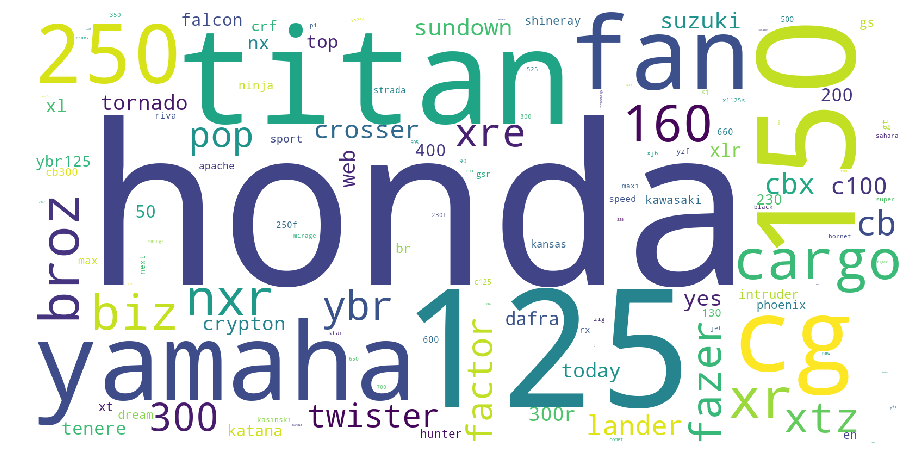

In [52]:
# Exibe a imagem da nova WordCloud gerada
fig, ax = plt.subplots(figsize=(20,8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

In [53]:
# Exporta para um aquivo
wordcloud.to_file("./imagens/wordcloud_descricoes_final.png")

In [54]:
tempotot=time.time()-initot
if tempotot>60:
    print(f'Tempo total de execução: {tempotot/60:.2f} minutos.')
else:
    print(f'Tempo total de execução: {tempotot:.2f} segundos.')

Tempo total de execução: 16.82 minutos.
